In [20]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

from cuped_utils import *

In [17]:
def many_cuped_sims(
    n_sims = 100,
    seed = 123
):
    meta_rng = np.random.default_rng(seed=seed)
    simple = np.zeros(n_sims)
    cuped = np.zeros(n_sims)
    adjust = np.zeros(n_sims)
    for i in range(n_sims):
        data = cuped_generator(seed=meta_rng.integers(1,100000))

        cuped_lm = sm.OLS(data['Post_trigger'], data['Pre_trigger']).fit()
        theta = cuped_lm.params[0]
        data['Post_cuped'] = data['Post_trigger'] - theta*data['Pre_normalized']

        reg = smf.ols("Post_trigger ~ Treatment",data).fit()
        simple[i] = reg.params['Treatment']

        cuped_reg = smf.ols("Post_cuped ~ Treatment", data).fit()
        cuped[i] = cuped_reg.params['Treatment']

        reg_adj = smf.ols(
            formula="Post_trigger ~ Treatment + Pre_trigger + Treatment:Pre_normalized",
            data=data).fit()
        adjust[i] = reg_adj.params['Treatment']
    return simple, cuped, adjust

<AxesSubplot:xlabel='estimate', ylabel='Density'>

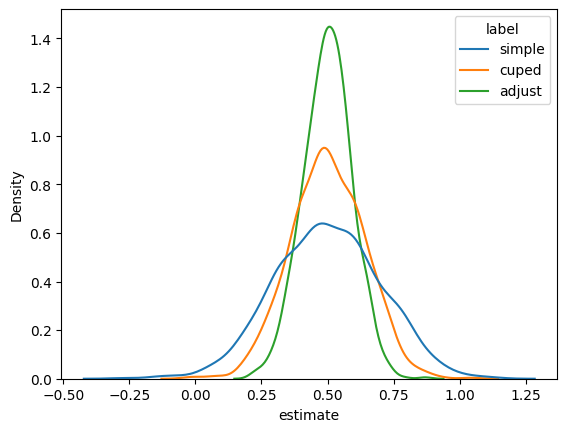

In [24]:
n = 1000
simple, cuped, adjust = many_cuped_sims(n_sims=n)
df = pd.DataFrame()
simple_df = pd.DataFrame({'label':['simple']*n, 'estimate':simple})
cuped_df = pd.DataFrame({'label':['cuped']*n, 'estimate':cuped})
adjust_df = pd.DataFrame({'label':['adjust']*n, 'estimate':adjust})

df = df.append([simple_df, cuped_df, adjust_df])
sns.kdeplot(x='estimate', hue = 'label', data=df)

In [3]:
data = cuped_generator()
reg = smf.ols("Post_trigger ~ Treatment",data).fit()
reg.get_robustcov_results('HC2').summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Post_trigger   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.017
No. Observations:                 500   F-statistic:                     9.640
Covariance Type:                  HC2   Prob (F-statistic):            0.00201
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.0120      0.132     60.518      0.000       7.752       8.272
Treatment      0.6232      0.201      3.105      0.002       0.229       1.018
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

In [5]:
cuped_lm = sm.OLS(data['Post_trigger'], data['Pre_trigger']).fit()
theta = cuped_lm.params[0]
data['Post_cuped'] = data['Post_trigger'] - theta*data['Pre_normalized']
cuped_reg = smf.ols("Post_cuped ~ Treatment", data).fit()
cuped_reg.get_robustcov_results('HC2').summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Post_cuped   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.022
No. Observations:                 500   F-statistic:                     11.98
Covariance Type:                  HC2   Prob (F-statistic):           0.000584
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.0786      0.096     83.955      0.000       7.890       8.268
Treatment      0.4845      0.140      3.461      0.001       0.209       0.759
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

In [6]:
reg_adj = smf.ols(
    formula="Post_trigger ~ Treatment + Pre_trigger + Treatment:Pre_normalized",
    data=data).fit()
reg_adj.get_robustcov_results('HC2').summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Post_trigger   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.787
No. Observations:                 500   F-statistic:                     665.8
Covariance Type:                  HC2   Prob (F-statistic):          1.89e-173
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    3.2001      0.175     18.334      0.000       2.857       3.543
Treatment                    0.5360      0.093      5.757      0.000       0.353       0.719
Pre_trigger                  0.9568      0.033     29.373      0.000       0.893       1.021
Treatment:Pre_normalized     0.0303      0.045      0.680      0.497      -0.057       0.118
============================================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""